In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import heapq
from numpy import linalg as LA

In [3]:
tolerance = 0.001

# Please use this setup for assignment 1
np.random.seed(5467)
env = gym.make('FrozenLake-v0',desc=None,map_name=None)
env.seed(48304)
env._max_episode_steps = 1000

env.render()


SFHFFFFF
FFFFFFFH
HHFFHFFF
FFFFFFFF
HFFFFFFF
FFFFFFFH
HFFHHFFH
FFFFHHFG


In [4]:
# We are not supposed to peek into the model
# But for this assignment we will
P=env.P
nA=env.nA
nS=env.nS
# Demo of how to peek and use P# You can run this and inspect the printout to understand the structure
# of entries in P
s=np.random.randint(nS)
a=np.random.randint(nA)

print(env.action_space)

# print("at state ",s," using action ",a)
# print("Transition to: ",P[s][a])
# print(type(P))
# print(P)

Discrete(4)


In [0]:
# This is the agent that performs Value Iteration

class VIagent:
    def __init__(self,env):
        self.P=env.P
        self.nA=env.nA
        self.nS=env.nS
        self.max_steps=env._max_episode_steps
        self.values = np.random.random(env.observation_space.n)
        self.policy = np.zeros(env.observation_space.n)  # Doesn't matter if initial policy is random or not
        self.tolerance = 0.001
        self.val1=[]
        self.val2=[]
        self.tick=0
        self.tock=0
        
    def value_iteration(self):
        no_of_backups=0
        while True:
            delta=0
            previous_values = np.copy(self.values)
            
            for state in range(nS):
                Q=[]
                
                for action in range(nA):
                    expected_future_rewards=[]
                    
                    for next_state_prob in P[state][action]:
                        prob, nextstate, reward, is_terminal = next_state_prob
                        
                        #Here we perform the core calculation of the equation given in the algorithm
                        expected_future_rewards.append((prob * (reward + self.values[nextstate])))
                
                    Q.append(sum(expected_future_rewards))  #Summation

                
                self.values[state] = max(Q)  #choosing the Max reward
                no_of_backups +=1
                delta = max(delta,abs(self.values[state]-previous_values[state]))
            
            if (delta < self.tolerance):
                break
            self.tick=time.time()    
            self.val1.append(self.mean_rewards_per_500())
            self.val2.append(no_of_backups)
            self.tock=time.time()    
                
        return self.values
    
    def policy_extract(self):
        
        for state in range(self.nS):
            
            q_stateaction=[]
            for action in range(self.nA):
                
                expected_future_rewards=[]
                for next_state_prob in P[state][action]:
                    
                    prob, nextstate, reward, is_terminal = next_state_prob
                    expected_future_rewards.append(prob*(reward + self.values[nextstate]))
                
                q_stateaction.append(sum(expected_future_rewards))
            
            self.policy[state]=np.argmax(q_stateaction)
            
        
        return self.policy
        


          
    def choose_action(self,observation):

        return self.policy[observation]

                        
                        
    def mean_rewards_per_500(self):
        self.policy_extract()
        total_reward = 0
        for episodes in range(500):
            observation = env.reset()
            for _ in range(1000):

                action = self.choose_action(observation)
                observation, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    observation = env.reset()
                    break
        return (total_reward/500)
  

In [5]:
viagent = VIagent(env)
viagent.value_iteration()
print("Value Iteration is performed \n\n")
print(viagent.values,"\n\n")
viagent.policy_extract()
print("Policy is now extracted\n\n")
print(viagent.policy)

#print(viagent.val1,viagent.val2)
print("\n The total time to perform 500 episodes in seconds is ",(viagent.tock-viagent.tick))

Value Iteration is performed 


[1.3538318  1.35530254 0.98574338 1.37274484 1.37490713 1.37677084
 1.37720243 1.375832   1.35530254 1.35866643 1.36619704 1.37271684
 1.37509914 1.37831957 1.37893455 0.70490277 0.15177142 0.18731305
 1.36867355 1.37170987 0.60918772 1.38050182 1.38187287 1.38231193
 0.61453438 1.07814819 1.36953902 1.37440542 1.37849244 1.38248395
 1.38394904 1.38389659 0.012981   1.25175389 1.36690231 1.37427961
 1.37976335 1.38411129 1.38654825 1.3849499  0.87587565 1.31164377
 1.35825248 1.36992312 1.37783635 1.38435875 1.39158015 0.68465151
 0.44121591 1.32644034 1.33937182 0.72898898 0.99459406 1.26092876
 1.4041266  0.25490554 1.32732992 1.32994681 1.33424709 1.03141099
 0.13811882 0.82091875 1.56001857 0.71605823] 


Policy is now extracted


[1. 0. 0. 2. 2. 2. 0. 3. 3. 3. 1. 2. 3. 2. 0. 0. 0. 0. 2. 0. 0. 2. 1. 1.
 3. 1. 2. 2. 1. 2. 1. 1. 0. 2. 2. 2. 2. 2. 1. 3. 1. 2. 2. 3. 3. 3. 0. 0.
 0. 2. 0. 0. 0. 3. 0. 0. 1. 1. 0. 0. 0. 0. 2. 0.]

 The total time to perform

Prioritized Sweeping Converges to
the Optimal Value Function
by **Lihong Li** and **Michael L. Littman**

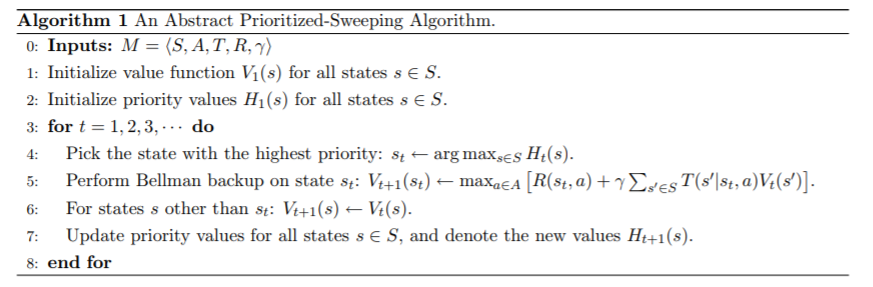

In [0]:
# This is the agent that performs Prioritized Value Iteration

class PSVIagent:
    def __init__(self,env,no_of_dequeue):
        self.P=env.P
        self.nA=env.nA
        self.nS=env.nS
        self.dequeues=no_of_dequeue
        self.max_steps=env._max_episode_steps
        self.values = np.random.random(env.observation_space.n)
        self.policy = np.zeros(env.observation_space.n)  # Doesn't matter if initial policy is random or not
        self.tolerance = 0.0009
        self.pr = np.ones(env.observation_space.n)
        self.val1=[]
        self.val2=[]
        self.tick=0
        self.tock=0
        self.dependent_states=[]

        for _ in range(nS):
            self.dependent_states.append([])
        

        for s in range(nS):
           for a in range(nA):
              for temp in P[s][a]:
                  prob, nextstate, reward, is_terminal = temp
                  self.dependent_states[nextstate].append(s)

                      
          
    def value_iteration(self):
        no_of_backups=0
        flo = True
        count=0
        while flo==True:
            delta=0
            previous_values = np.copy(self.values)
            
            for _ in range(self.dequeues):
                Q=[]
                
                #print("========")
                state = np.argmax(self.pr)
                #print(state)
                for action in range(nA):
                    expected_future_rewards=[]
                    
                    for next_state_prob in P[state][action]:
                        prob, nextstate, reward, is_terminal = next_state_prob
                        
                        #Here we perform the core calculation of the equation given in the algorithm
                        expected_future_rewards.append((prob * (reward + self.values[nextstate])))
                        
                    Q.append(sum(expected_future_rewards))  #Summation

                
                self.values[state] = max(Q)  #choosing the Max reward
                no_of_backups +=1
                delta = max(delta,abs(self.values[state]-previous_values[state]))
                # delta=np.amax(np.absolute(self.values-previous_values))
                # # delta = np.linalg.norm(self.values-previous_values,1)
                self.pr[state]=abs(self.values[state]-previous_values[state])



                for e in self.dependent_states[state]:
                  self.pr[e]=abs(self.values[state]-previous_values[state])
            #print(delta)               
            count+=1
            # if (delta < self.tolerance):
            #     break
            self.tick=time.time()    
            self.val1.append(self.mean_rewards_per_500())
            self.val2.append(no_of_backups)
            self.tock=time.time()  

            if(count >= 1500):
                break  
                
        return self.values
    
    def policy_extract(self):
        
        for state in range(self.nS):
            
            q_stateaction=[]
            for action in range(self.nA):
                
                expected_future_rewards=[]
                for next_state_prob in P[state][action]:
                    
                    prob, nextstate, reward, is_terminal = next_state_prob
                    expected_future_rewards.append(prob*(reward + self.values[nextstate]))
                
                q_stateaction.append(sum(expected_future_rewards))
            
            self.policy[state]=np.argmax(q_stateaction)
            
        
        return self.policy
        


          
    def choose_action(self,observation):

        return self.policy[observation]

                        
                        
    def mean_rewards_per_500(self):
        self.policy_extract()
        total_reward = 0
        for episodes in range(500):
            observation = env.reset()
            for _ in range(1000):

                action = self.choose_action(observation)
                observation, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    observation = env.reset()
                    break
        return (total_reward/500)
  

In [0]:
psagent10 = PSVIagent(env,10)
psagent10.value_iteration()

psagent18 = PSVIagent(env,25)
psagent18.value_iteration()





In [15]:
psagent25 = PSVIagent(env,18)
psagent25.value_iteration()

array([1.14439014, 1.14439515, 0.51704816, 1.22602444, 1.22824219,
       1.22985709, 1.22953564, 1.22949927, 1.09840737, 1.14515642,
       1.19266676, 1.22391983, 1.2274542 , 1.23020057, 1.23014851,
       0.72132429, 0.32670199, 0.38915531, 1.20898413, 1.21861539,
       0.61730681, 1.23084012, 1.23070934, 1.2305778 , 0.76535626,
       1.04271635, 1.21614361, 1.2229422 , 1.22776564, 1.23161046,
       1.23204119, 1.2304864 , 0.48799617, 1.14677818, 1.21650451,
       1.22414333, 1.22892813, 1.23216379, 1.23380377, 1.2296953 ,
       0.83455492, 1.18111367, 1.21105027, 1.22068285, 1.22685497,
       1.23107712, 1.23789425, 0.68864145, 0.33765186, 1.18964391,
       1.19605375, 0.3788768 , 0.79188773, 1.09932119, 1.24949731,
       0.01361717, 1.19176019, 1.1917643 , 1.19388956, 0.92951472,
       0.6672793 , 0.81738914, 1.41272654, 0.57597893])

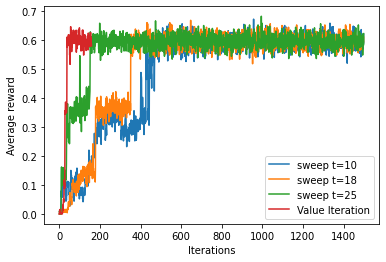

In [23]:

plt.plot(psagent10.val1,label="sweep t=10")
plt.plot(psagent25.val1,label="sweep t=18")
plt.plot(psagent18.val1,label="sweep t=25")
plt.plot(viagent.val1,label="Value Iteration")


plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.legend()


plt.show()

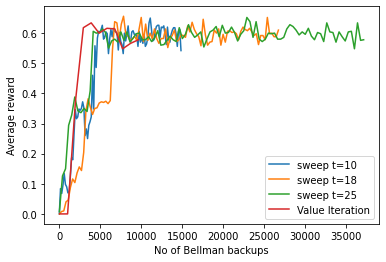

In [22]:
plt.plot(psagent10.val2[::15],psagent10.val1[::15],label="sweep t=10")
plt.plot(psagent25.val2[::15],psagent25.val1[::15],label="sweep t=18")
plt.plot(psagent18.val2[::15],psagent18.val1[::15],label="sweep t=25")

plt.plot(viagent.val2[::15],viagent.val1[::15],label="Value Iteration")


plt.xlabel("No of Bellman backups")
plt.ylabel("Average reward")
plt.legend()


plt.show()
